In [1]:
import numpy as np   
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.animation import FuncAnimation

d_phi = 0.02
phi_min = -np.pi
phi_max = np.pi
m = 100
g = 0.01
l = 1
phi = np.arange(phi_min, phi_max, d_phi)
print(f"len(phi): {len(phi)}")
print(f"phi_check: {phi[0]} {phi[-1]}")
print(f"1/m: {1/m}")
print(f"mgl: {m*g*l}")


# KE_constant = 0.00001
# PE_constant = 0.1

dt = 0.01
steps = 100000
# gaussian with periodic boundary conditions
kappa = 5
phi_0 = 1
phi_0 = np.pi - 0.5
psi_phi = np.exp(kappa * np.cos(phi-phi_0))
psi_phi = psi_phi / np.sqrt(np.sum(np.abs(psi_phi)**2) * d_phi)


len(phi): 315
phi_check: -3.141592653589793 3.1384073464102125
1/m: 0.01
mgl: 1.0


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def momentum_operator_periodic(psi, d_phi):
    '''
    Calculate the momentum operator acting on the wavefunction psi with periodic boundary conditions.
    '''
    # create an array to hold the derivative
    d_psi = np.zeros(psi.shape, dtype=complex)
    
    # calculate the derivative
    for i in range(1, len(psi)-1):
        d_psi[i] = (psi[i+1] - psi[i-1]) / (2*d_phi)
    
    # calculate the derivative at the end points
    d_psi[0] = (psi[1] - psi[-1]) / (2 * d_phi)
    d_psi[-1] = (psi[0] - psi[-2]) / (2 * d_phi)
    
    return -1j * d_psi

def pendulum_potential_periodic(phi, m, g, l):
    return m * g * l * (1 - np.cos(phi))

def d_psi_pendulum(psi_phi, phi, d_phi, m=1e5, g=1e-3, l=1):
    # Calculate H_psi
    H_psi = 0.5 * (1/(m * l ** 2)) * momentum_operator_periodic(momentum_operator_periodic(psi_phi, d_phi), d_phi) + pendulum_potential_periodic(phi, m, g, l) * psi_phi
    # The derivative of psi_x is 1j * H_psi
    return -1j * H_psi

def euler_step(psi_phi, phi, d_phi, dt):
    return psi_phi + d_psi_pendulum(psi_phi, phi, d_phi) * dt

def energy(psi_phi, phi, d_phi, m=1e5, g=1e-3, l=1):
    # Calculate H_psi
    H_psi = 0.5 * (1/(m * l ** 2)) * momentum_operator_periodic(momentum_operator_periodic(psi_phi, d_phi), d_phi) + pendulum_potential_periodic(phi, m, g, l) * psi_phi

    return np.sum(np.conj(psi_phi) * H_psi) * d_phi

def phi_expectation(psi_phi, phi, d_phi):
    return np.sum(np.conj(psi_phi) * phi * psi_phi) * d_phi

def rk_step(psi_phi, phi, d_phi, dt, m, g, l):
    k1 = d_psi_pendulum(psi_phi, phi, d_phi, m, g, l)
    k2 = d_psi_pendulum(psi_phi + 0.5 * dt * k1, phi, d_phi, m, g, l)
    k3 = d_psi_pendulum(psi_phi + 0.5 * dt * k2, phi, d_phi, m, g, l)
    k4 = d_psi_pendulum(psi_phi + dt * k3, phi, d_phi, m, g, l)

    return psi_phi + dt / 6 * (k1 + 2*k2 + 2*k3 + k4)

In [3]:

step_frequency = 1000
psi_phi_t = np.zeros(shape=(step_frequency, len(psi_phi)), dtype=complex)
phi_expectations = np.zeros(shape=(step_frequency))
energy_t = np.zeros(shape=(step_frequency))
for i in range(steps):
    psi_phi = rk_step(psi_phi, phi, d_phi, dt, m, g, l)

    if i % int(steps/step_frequency) == 0:
        print(f"i: {i}")
        # record psi_x
        psi_phi_t[int(i/int(steps/step_frequency))] = psi_phi
        phi_expectations[int(i/int(steps/step_frequency))] = np.real(phi_expectation(psi_phi, phi, d_phi))
        energy_t[int(i/int(steps/step_frequency))] = energy(psi_phi, phi, d_phi, m, g, l)
        print(f"Energy: {energy_t[int(i/int(steps/step_frequency))]}")
        print(f"Position Expectation: {phi_expectations[int(i/int(steps/step_frequency))]}")
        np.save("data/psi_phi_t_progress.npy", psi_phi_t)

    # E = energy(psi_phi, d_phi, m, g, l)
    # if np.real(E) > 5:
    #     break

<ipython-input-3-6ada768aa8c5>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_t[int(i/int(steps/step_frequency))] = energy(psi_phi, phi, d_phi, m, g, l)


i: 0
Energy: 1.8451780549399655
Position Expectation: 2.2383201181535783
i: 100
Energy: 1.8451780545480188
Position Expectation: 2.239783252933086
i: 200
Energy: 1.8451780541560738
Position Expectation: 2.2315768640592837
i: 300
Energy: 1.8451780537641325
Position Expectation: 2.216001487555743
i: 400
Energy: 1.8451780533721935
Position Expectation: 2.1936510426466764
i: 500
Energy: 1.8451780529802566
Position Expectation: 2.165027531289076
i: 600
Energy: 1.845178052588322
Position Expectation: 2.130589033812125
i: 700
Energy: 1.8451780521963903
Position Expectation: 2.0907202274520853
i: 800
Energy: 1.8451780518044612
Position Expectation: 2.045703648455921
i: 900
Energy: 1.8451780514125338
Position Expectation: 1.995707386494388
i: 1000
Energy: 1.8451780510206102
Position Expectation: 1.9407902514719377
i: 1100
Energy: 1.8451780506286877
Position Expectation: 1.8809201037783396
i: 1200
Energy: 1.845178050236769
Position Expectation: 1.8159997620161705
i: 1300
Energy: 1.84517804984485

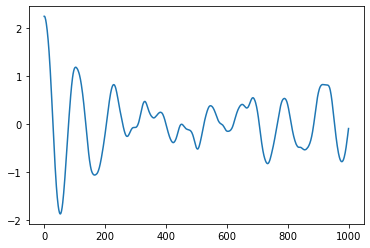

In [4]:
# plot phi_expectations
plt.plot(phi_expectations)
plt.show()

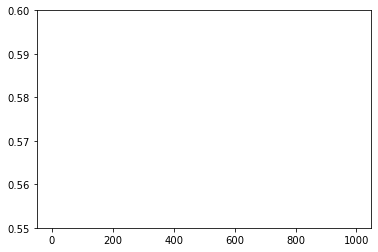

In [5]:
# plot energies
plt.plot(energy_t[:5000])
plt.ylim(0.55, 0.60)
plt.show()

In [6]:
# save psi_phi_t
np.save(f"data/psi_phi_t_m={m},g={g},l={l},kappa={kappa},phi_0={phi_0}.npy", psi_phi_t)